In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils

import numpy as np
from matplotlib import pyplot as plt

from models import LSTM_1D_TimeSeries as LSTM
from train import train_lambda, eval_lambda

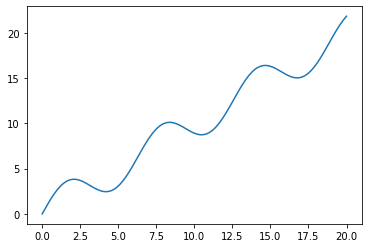

In [2]:
signal = lambda t: 2*np.sin(t) + t# + np.random.normal(loc=0.0, scale=0.3, size=t.shape)
ticks = np.linspace(0, 20, 200)
plt.plot(ticks, signal(ticks))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
torch.manual_seed(1)

  0%|          | 0/3000 [00:00<?, ?it/s]

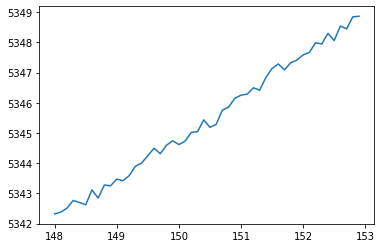

In [4]:
f = 50
tr = 48
lstm = LSTM(16, int(tr/0.1), future = f)
train_lambda(lstm, signal, future = f, time_range=tr, epochs = 3000, dev = device)

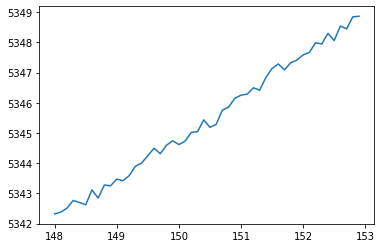

In [6]:
eval_lambda(lstm, signal, time_range=tr, eval_from=8000)